## SOFI 2D Model Builder
- This code shows an interactive and step-by-step code to generate 2D models ready to run in SOFI2D
- Structures and examples are focused on acoustic well-logging applications
- Currently, only vertical or horizontal features can be incorporated in the model

##### Reference:
I used - SOFI 2D - User Guide written by Thomas Bohlen, Denise De Nil, Daniel Kohn and Stefan Jetschny

Link: https://git.scc.kit.edu/GPIAG-Software/SOFI2D/-/wikis/home


#### Imported Libraries

In [50]:
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames for tabular data
import matplotlib.pyplot as plt                           # plotting
import pandas.plotting as pd_plot
from sklearn.cluster import DBSCAN        # DBSCAN clustering
from sklearn.preprocessing import MinMaxScaler # min/max normalization
import seaborn as sns
import json

#### Functions

In [51]:
def plotmodels(xx_grid,yy_grid,zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs):
    plt.subplot(2,3,1)
    im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
    plt.title('P-wave model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im1, orientation = 'vertical')
    cbar.set_label("P-wave velocity (m/s)")

    plt.subplot(2,3,2)
    im2 = plt.contourf(xx_grid, yy_grid, zz_Vs,500,cmap=plt.cm.jet,norm=None)
    plt.title('S-wave model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im2, orientation = 'vertical')
    cbar.set_label("S-wave velocity (m/s)")

    plt.subplot(2,3,3)
    im3 = plt.contourf(xx_grid, yy_grid, zz_Rho,500,cmap=plt.cm.jet,norm=None)
    plt.title('Density model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im3, orientation = 'vertical')
    cbar.set_label("Density (kg/m^3)")

    plt.subplot(2,3,4)
    im4 = plt.contourf(xx_grid, yy_grid, zz_Qp,500,cmap=plt.cm.jet,norm=None)
    plt.title('P-wave attenuation model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im4, orientation = 'vertical')
    cbar.set_label("P-wave attenuation")

    plt.subplot(2,3,5)
    im5 = plt.contourf(xx_grid, yy_grid, zz_Qs,500,cmap=plt.cm.jet,norm=None)
    plt.title('S-wave attenuation model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im5, orientation = 'vertical')
    cbar.set_label("S-wave attenuation")

    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3, wspace=0.2, hspace=0.2)
    
def SRPlacement(dh_model,x_start,x_end,y_start,y_end):
    xgrid_start=int(np.round(x_start/dh_model))
    xgrid_end=int(np.round(x_end/dh_model))
    ygrid_start=int(np.round(y_start/dh_model))
    ygrid_end=int(np.round(y_end/dh_model))
    if xgrid_end-xgrid_start==0:
        if ygrid_end-ygrid_start==0:
            XSRC_grid=xgrid_start
            YSRC_grid=ygrid_start
        else:
            XSRC_grid=np.ones(ygrid_end-ygrid_start)*xgrid_start
            YSRC_grid=np.arange(ygrid_start,ygrid_end,1)
    else:
        if ygrid_end-ygrid_start==0:
            YSRC_grid=np.ones(xgrid_end-xgrid_start)*ygrid_start
            XSRC_grid=np.arange(xgrid_start,xgrid_end,1)
        else:
            b=(ygrid_end-ygrid_start)/(xgrid_end-xgrid_start)
            a=ygrid_start-b*xgrid_start
            if xgrid_end-xgrid_start>ygrid_end-ygrid_start:
                YSRC_grid=np.ones(xgrid_end-xgrid_start)
                XSRC_grid=np.arange(xgrid_start,xgrid_end,1)
                for n in range(len(YSRC_grid)):
                    YSRC_grid[n]=int(round(a+b*XSRC_grid[n]))
            else:
                XSRC_grid=np.ones(ygrid_end-ygrid_start)
                YSRC_grid=np.arange(ygrid_start,ygrid_end,1)
                for n in range(len(YSRC_grid)):
                    XSRC_grid[n]=int(round((YSRC_grid[n]-a)/b))
    return XSRC_grid, YSRC_grid

### 1. Defining the grid
Optimal grid dimensions definition requires knowledge of:
- Maximum and minimum velocities
- Maximum frequency

These two set of parameters give recommended grid size $dh$ and time step $DT$
After that, knowledge of model dimensions is required:
- X-Y Dimensions
- Modeling time span

These second set of parameters are in charge of defining total number of steps $NT$ and grid dimension $NX$ and $NY$


In [52]:
#Model Parameters
ModelMaxVel=3500                    #Maximum velocity (in m/s)
ModelMinVel=2000                    #Minimum velocity (in m/s)
MaxFrequency=10                     #Maximum frequency required (in Hz)

n_Taylor=[12,8,6,5,5,4]                                                  #Spatial Taylor coefficients (unitless)
dh_Taylor=np.zeros(len(n_Taylor))
h_Taylor=[1,7/6,149/120,2161/1680,53089/40320,1187803/887040]            #Time Taylor coefficients (unitless)
dt_Taylor=np.zeros([len(n_Taylor),len(h_Taylor)])
#I generate a dataframe with dh and dt values using Taylor coefficients
for n in range(len(n_Taylor)):
    dh_Taylor[n]=ModelMinVel/(n_Taylor[n]*MaxFrequency)
    for m in range(len(n_Taylor)):
        dt_Taylor[n,m]=dh_Taylor[n]/(h_Taylor[m]*np.sqrt(2)*ModelMaxVel)
d={'n_Taylor':n_Taylor,'dh':dh_Taylor}
df_grid_Taylor = pd.DataFrame(data=d)

for n in range(len(h_Taylor)):
    df_grid_Taylor['h_'+str(np.round(h_Taylor[n],decimals=2))]=dt_Taylor[:,n]

    
df_grid_Taylor.head(n=len(n_Taylor))    

,n_Taylor,dh,h_1,h_1.17,h_1.24,h_1.29,h_1.32,h_1.34
0,12,16.666667,0.003367,0.002886,0.002712,0.002618,0.002557,0.002515
1,8,25.000000,0.005051,0.004329,0.004068,0.003927,0.003836,0.003772
2,6,33.333333,0.006734,0.005772,0.005424,0.005235,0.005115,0.005029
3,5,40.000000,0.008081,0.006927,0.006508,0.006282,0.006138,0.006035
4,5,40.000000,0.008081,0.006927,0.006508,0.006282,0.006138,0.006035
5,4,50.000000,0.010102,0.008658,0.008135,0.007853,0.007672,0.007544


In [53]:
#I generate a dataframe with dh and dt values using Holberg coefficients
n_Holberg=[12,8.32,4.77,3.69,3.19,2.91]
dh_Holberg=np.zeros(len(n_Holberg))
h_Holberg=[1,1.1846146,1.283482,1.345927,1.387660,1.417065]
dt_Holberg=np.zeros([len(n_Holberg),len(h_Holberg)])
for n in range(len(n_Holberg)):
    dh_Holberg[n]=ModelMinVel/(n_Holberg[n]*MaxFrequency)
    for m in range(len(n_Holberg)):
        dt_Holberg[n,m]=dh_Holberg[n]/(h_Holberg[m]*np.sqrt(2)*ModelMaxVel)
d={'n_Holberg':n_Holberg,'dh':dh_Holberg}
df_grid_Holberg = pd.DataFrame(data=d)

for n in range(len(h_Holberg)):
    df_grid_Holberg['h_'+str(np.round(h_Holberg[n],decimals=2))]=dt_Holberg[:,n]

    
df_grid_Holberg.head(n=len(n_Holberg))  

,n_Holberg,dh,h_1,h_1.18,h_1.28,h_1.35,h_1.39,h_1.42
0,12.00,16.666667,0.003367,0.002842,0.002623,0.002502,0.002427,0.002376
1,8.32,24.038462,0.004857,0.004100,0.003784,0.003608,0.003500,0.003427
2,4.77,41.928721,0.008471,0.007151,0.006600,0.006294,0.006104,0.005978
3,3.69,54.200542,0.010950,0.009244,0.008532,0.008136,0.007891,0.007727
4,3.19,62.695925,0.012666,0.010692,0.009869,0.009411,0.009128,0.008939
5,2.91,68.728522,0.013885,0.011721,0.010818,0.010317,0.010006,0.009799


In [54]:
#Once I define my dh and dt for the model, I build my grid
dh_model=50                                       #model grid size (in m)
dt_model=0.006                                    #time step (in s)
#Then I define the dimensions of the grid
X_length=5400                                     #grid length along X-direction   (in m)
Y_length=5400                                     #grid length along Y-direction   (in m)
T_length=5                                        #simulation time                 (in s)
#And then I can create my grid
NX=int(np.round(X_length/dh_model))                    #grid size along X-direction     (number of cells)
NY=int(np.round(Y_length/dh_model))                    #grid size along Y-direction     (number of cells)
NT=int(np.round(T_length/dt_model))                    #Total number of steps

print('Grid has the following dimensions. X:'+str(np.round(NX))+',Y:'+str(np.round(NY))+' and a total of '+str(np.round(NY))+' steps.')

Grid has the following dimensions. X:108,Y:108 and a total of 108 steps.


### 2. Defining the model
Once I generate the grid, I generate a base model using a single layer with the initial parametrical values: P-wave model, S-wave model, Density model, P-wave attenuation model and S-wave attenuation model.
- Each layer has a constant value for each parameter
- Every subsequent layer replaces the preexisting value of parameter within the layer grid
- Layer input is done through grid coordinates range and parameters

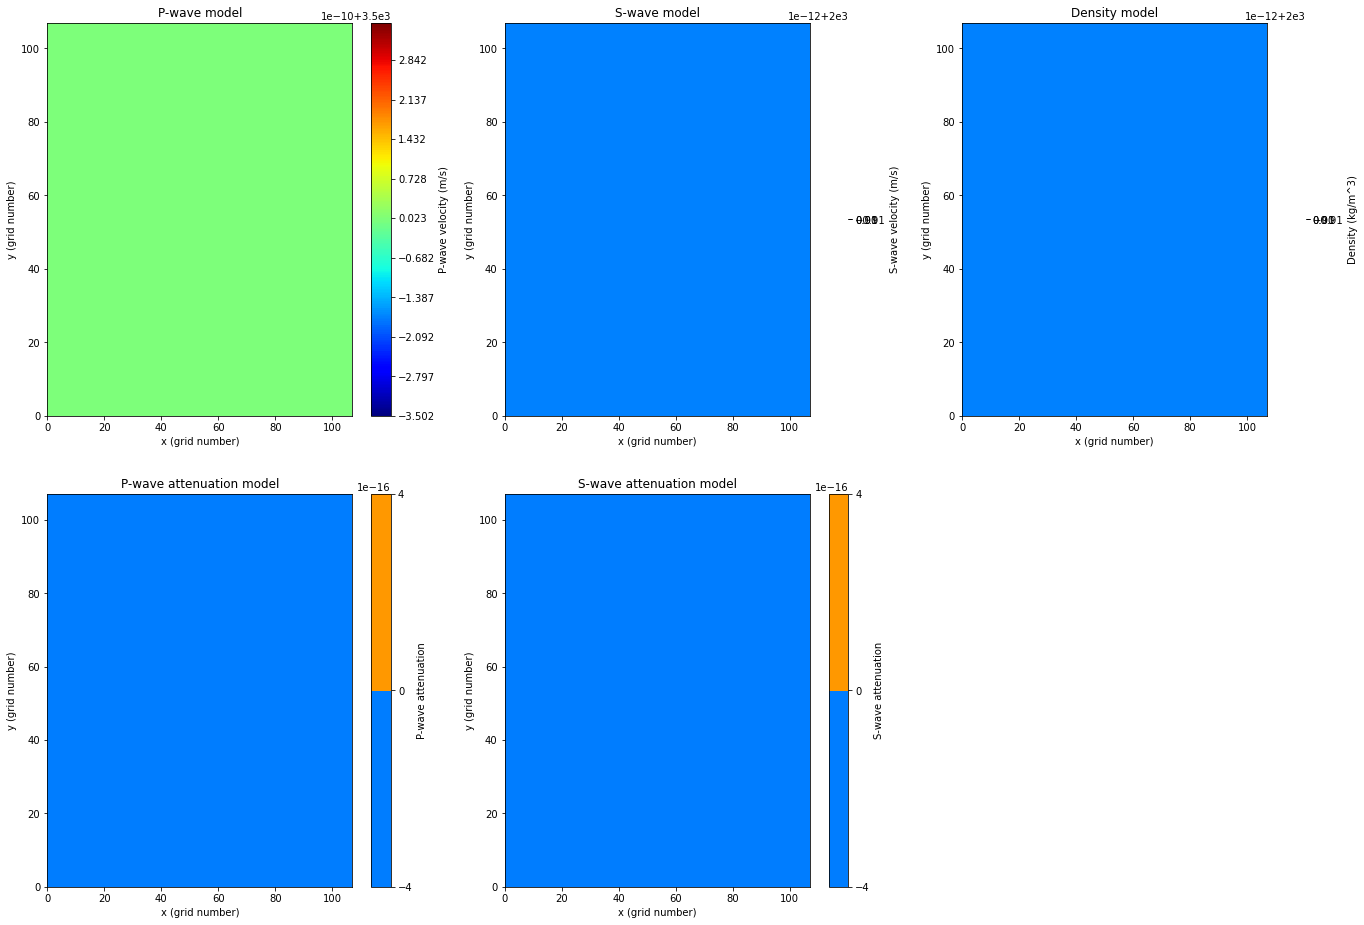

In [55]:
#Base layer
#Define parameters:
#P-wave velocity (m/s)
Vp=3500
#S-wave velocity (m/s)
Vs=2000
#Density (kg/m^3)
Rho=2000
#Vp-wave attenuation (unitless)
Qp=0
#Vs-wave attenuation (unitless)
Qs=0

#Grid generation and population
xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
zz_Vp=np.ones([NX,NY])*Vp
zz_Vs=np.ones([NX,NY])*Vs
zz_Rho=np.ones([NX,NY])*Rho
zz_Qp=np.ones([NX,NY])*Qp
zz_Qs=np.ones([NX,NY])*Qs

plotmodels(xx_grid,yy_grid,zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs)

Time to add layers
For every layer is added, the code below can be copied and pasted.

In [56]:
#Grid location (from distance to grid points)
Distxfrom=0
Distxto=5400
Distyfrom=1000
Distyto=2000

Gridxfrom=int(np.round(Distxfrom/dh_model))
Gridxto=int(np.round(Distxto/dh_model)-1) 
Gridyfrom=int(np.round(Distyfrom/dh_model)) 
Gridyto=int(np.round(Distyto/dh_model)-1)

print('Layer ranges from '+str(Gridxfrom)+' to '+str(Gridxto)+' along X axis')
print('and from '+str(Gridyfrom)+' to '+str(Gridyto)+' along Y axis')

Layer ranges from 0 to 107 along X axis
and from 20 to 39 along Y axis


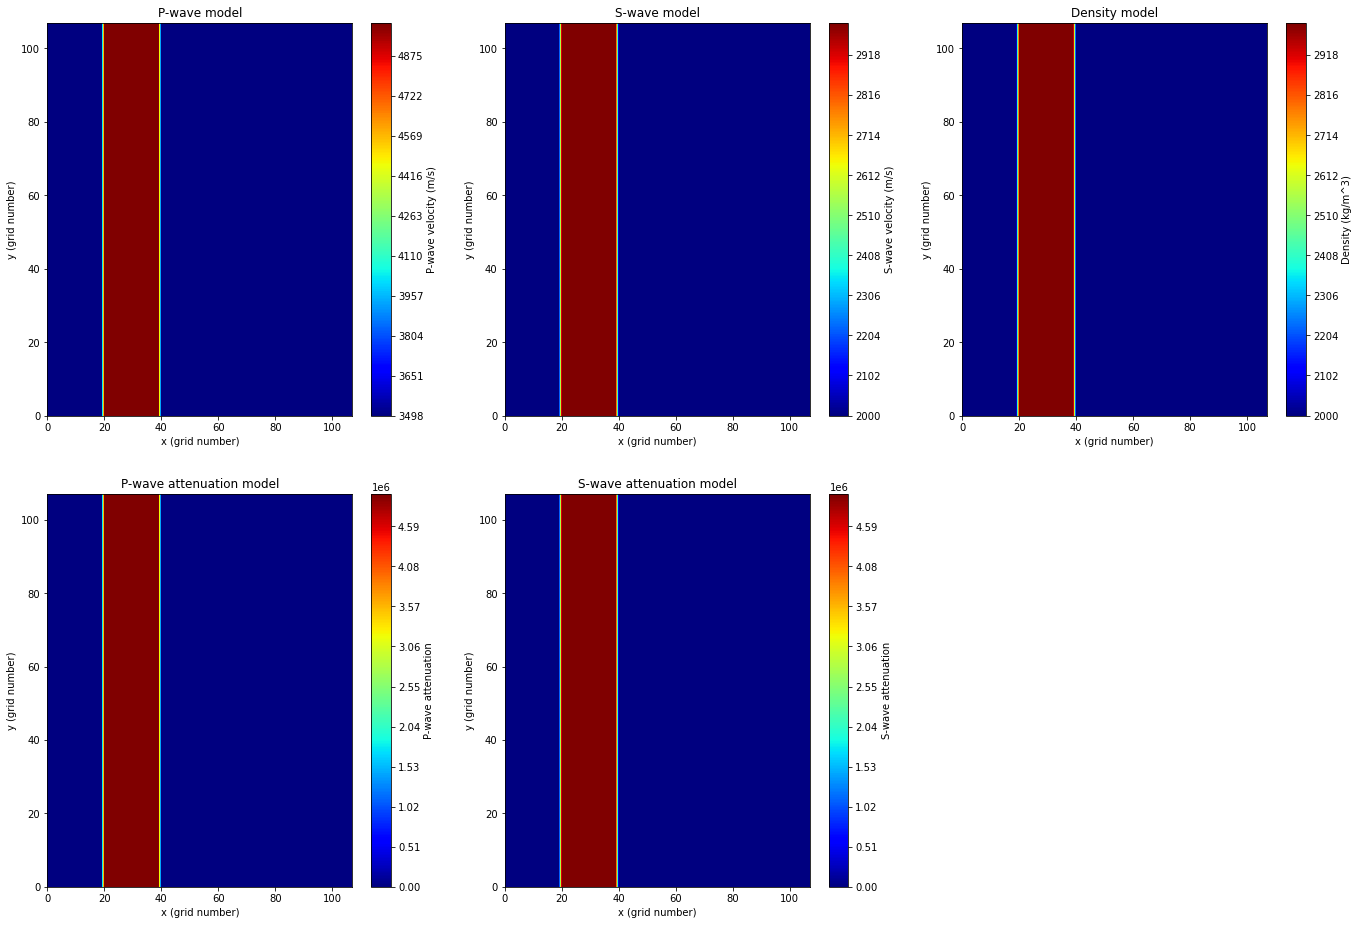

In [57]:
#Layer parameters
#P-wave velocity (m/s)
Vp=5000
#S-wave velocity (m/s)
Vs=3000
#Density (kg/m^3)
Rho=3000
#Vp-wave attenuation (unitless)
Qp=5000000
#Vs-wave attenuation (unitless)
Qs=5000000

for n in range(NX):
    for m in range(NY):
        if n>=Gridxfrom and n<=Gridxto and m>=Gridyfrom and m<=Gridyto:
            zz_Vp[n,m]=Vp
            zz_Vs[n,m]=Vs
            zz_Rho[n,m]=Rho
            zz_Qp[n,m]=Qp
            zz_Qs[n,m]=Qs

plotmodels(xx_grid,yy_grid,zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs)

### 3. Exporting the models
Each model is imported as a different file with extension .vp, .vs, .rho, .qp, and .qs for P-wave velocity, S-wave velocity, Density, P-wave attenuation, and S-wave attenuation, respectively

In [58]:
os.chdir("C:/Users/gg27788/Documents/Python Scripts/SOFI 2D - Input Builders") 

In [59]:
file=open('test.vp','wb')
np.save(file,zz_Vp.astype('float32'))
file.close()
file=open('test.vs','wb')
np.save(file,zz_Vs.astype('float32'))
file.close()
file=open('test.rho','wb')
np.save(file,zz_Rho.astype('float32'))
file.close()
file=open('test.qp','wb')
np.save(file,zz_Qp.astype('float32'))
file.close()
file=open('test.qs','wb')
np.save(file,zz_Qs.astype('float32'))
file.close()

### 4. Designing of JSON parameter file
Along this section I interactively set up json file parameters, as described in the SOFI2D guide.

#### 4.1 Domain

SOFI2D allows for multiprocessor processing by dividing the domain into subgrids.
The total number of processors must be specified when starting the program, defining NP:

mpirun - np <NP> ../bin/sofi2D < sofi2D.json
                                            
Parameters are:
- NPROCX : number of processors in x-direction
- NPROCY : number of processors in y-direction

If the total number of processors in sofi2D.json (calculated as NPROCX*NPROCY) and the command line differ the program will terminate with an error message

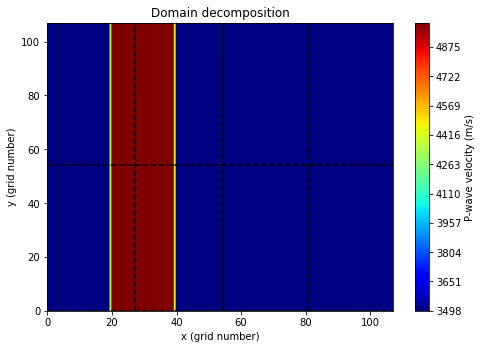

In [60]:
NPROCX=4
NPROCY=2

stepx=NX/NPROCX
stepy=NY/NPROCY

im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.title('Domain decomposition')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")
for n in range(NPROCX):
    plt.plot([n*stepx,n*stepx],[0,NY-1],'black',linestyle='dashed')
for m in range(NPROCY):
    plt.plot([0,NX-1],[m*stepy,m*stepy],'black',linestyle='dashed')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1, wspace=0.2, hspace=0.2)

##### JSON File

In [61]:
json_output={'Domain Decomposition':'comment','NPROCX':NPROCX,'NPROCY':NPROCY}

#### 4.2 Order of the FD Operator
In this step I define the order of the FD operator.
This section is related to section 1., where I defined the grid based on Taylor and Holberg operators.
Parameters are:
- FDORDER:Order of ssg FD coefficients (values: 2, 4, ..., 12)
- FDORDER_TIME: Order of temporal FD coefficients (values: 2 and 4)
- MAXRELERROR: Maximum relative group velocity error E and minimum number of grid points per shortest wavelengths where:
      - 0 --> Taylor coefficients
      - 1 --> Holberg coefficients
      - E=0.5%
      - E=1.0%
      - E=3.0%

In [62]:
FDORDER=2
FDORDER_TIME=2
MAXRELERROR=1

##### JSON File Update

In [63]:
json_update={'FD order':'comment','FDORDER':FDORDER,'FDORDER_TIME':FDORDER_TIME,'MAXRELERROR':MAXRELERROR}
json_output.update(json_update)

#### 4.3 Discretization
This step import parameters from sections 1 and 2 and checks stability.
Outputs are the initial parameters we defined first:
- NX: number of grid points in the x-direction
- NY: number of grid points in the y-direction
- DH: distance between grid points

I repeat the same stability check than the one performed by the code.

In [64]:
print('Grid has the following dimensions. X:'+str(np.round(NX))+',Y:'+str(np.round(NY))+' with a grid distance '+str(np.round(dh_model)))
vmin=2000
fc=5
N=8
dh_min=vmin/(2*fc*N)
print('Minimum grid size required for stability: '+str(dh_min)+' vs '+str(dh_model))

Grid has the following dimensions. X:108,Y:108 with a grid distance 50
Minimum grid size required for stability: 25.0 vs 50


##### JSON Update

In [65]:
json_update={'2-D Grid':'comment','NX':NX,'NY':NY,'DH':dh_model}
json_output.update(json_update)

#### 4.4 Time stepping
This step i double check that my time stepping is compliant with the minimum value
Parameters are:
- TIME: Experiment time
- DT: Time stepping interval

In [66]:
h_value=7/6
vmax=5000
dt_min=dh_model/(h_value*np.sqrt(2)*vmax)
print('Minimum step size required for stability: '+str(dt_min)+' vs '+str(dt_model))

Minimum step size required for stability: 0.006060915267313264 vs 0.006


##### JSON Update

In [67]:
json_update={'Time Stepping':'commnent','TIME':T_length,'DT':dt_model}
json_output.update(json_update)

#### 4.5 Source
In this section I define the shape, source type and location of sources.
Parameters are:
- SOURCE_SHAPE: Shape of source signal (Ricker=1, Fumue=2, using SIGNAL_FILE=3, sinus^3=4)
- SOURCE_TYPE: Point source (explosive=1, force in x=2, force in y=3)
- PLANE_WAVE_DEPTH: Depth of plane wave excitation in meters (if no=0)
- PLANE_WAVE_ANGLE: Dip of plane wave from vertical (in deg)
- TS: Duration of source signal
- SIGNAL_FILE: External signal file name
- SRCREC: Read source positions from external SOURCE_FILE (yes=1)
- SOURCE_FILE: File with source locations
- RUN_MULTIPLE_SHOTS: Multiple shots modeled simultaneously (0) or individually (1)

I subdivide this interval into Source Shape and Source Type/Location sections

##### Source Shape
Along this section I define the source shape. In case I use a plane wave, then SOURCE_SHAPE applies to the experiment, otherwise it is defined for each source in the source file.


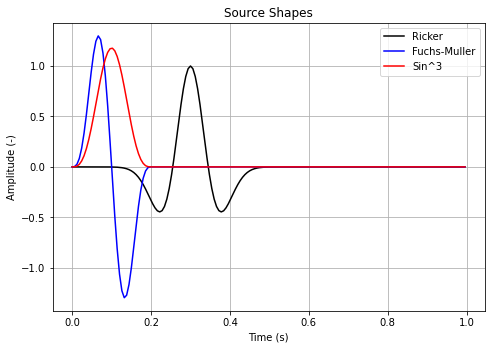

In [68]:
#Source shapes
TS=1                #Duration of source signal (s)
FC=5                #Central frequency (Hz)
TD=0                #Time delay (s)
#Defining the time vector
t=np.arange(0,TS,dt_model)
#Ricker wavelet
tau=np.pi*(t-1.5/FC-TD)/(1/FC)
r=(1-2*tau**2)*np.exp(-tau**2)
#Fuchs-Muller wavelet
fm=np.zeros(len(t))
scube=np.zeros(len(t))
for n in range(len(t)):
    if n*dt_model>=TD and n*dt_model<=TD+1/FC:
        fm[n]=np.sin(2*np.pi*(n*dt_model-TD)*FC)-0.5*np.sin(4*np.pi*(n*dt_model-TD)*FC)
    else:
        fm[n]=0
#Sin^3 wavelet
for n in range(len(t)):
    if n*dt_model>=TD and n*dt_model<=TD+1/FC:
        scube[n]=0.075*np.pi*FC*(np.sin(np.pi*(n*dt_model-TD)*FC))**3
    else:
        scube[n]=0

plt.plot(t,r,'black',label='Ricker')
plt.plot(t,fm,'blue',label='Fuchs-Muller')
plt.plot(t,scube,'red',label='Sin^3')
plt.legend(); plt.grid()
plt.title('Source Shapes')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (-)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1, wspace=0.2, hspace=0.2)

In [69]:
SOURCE_SHAPE=1
SIGNAL_FILE='signal_mseis.tz'
SRCREC=1
SOURCE_FILE='./sources/source.dat'
RUN_MULTIPLE_SHOTS=0

##### Source Type/Location
###### Plane wave

Plane waves are generated from a line source defined all along the domain.
In case a plane wave is used, the following parameters are required:
- PLANE_WAVE_DEPTH: Depth of plane wave excitation in meters (if no=0)
- PLANE_WAVE_ANGLE: Dip of plane wave from vertical (in deg)
Also, we recommend to set this parameter:
- SRCREC: Read source positions from external SOURCE_FILE (no=0)

The following code allows to interactively see the location and propagation direction of the plane wave

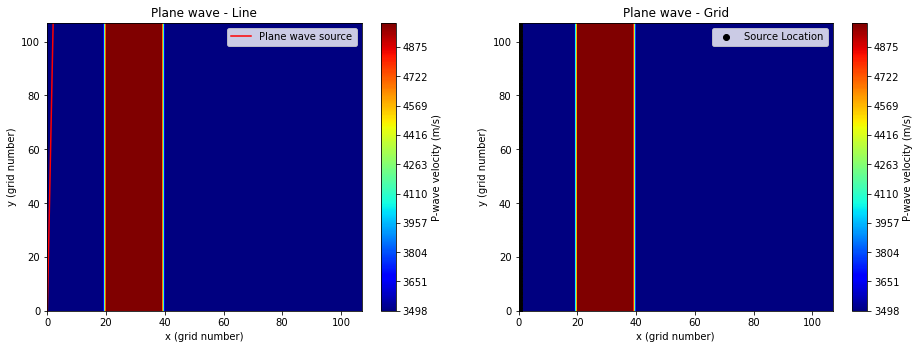

In [70]:
PLANE_WAVE_DEPTH=5                       #in m
PLANE_WAVE_ANGLE=89                       #in deg
TS=0.2
#The line source is defined as a slope y=a+bx where a=PLANE_WAVE_DEPTH and b=tan(PLANE_WAVE_ANGLE)
x_bottom=(Y_length-PLANE_WAVE_DEPTH)/np.tan(PLANE_WAVE_ANGLE*np.pi/180)

plt.subplot(1,2,1)
im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.plot([0,int(np.round(x_bottom/dh_model))],[int(np.round(PLANE_WAVE_DEPTH/dh_model)),int(np.round(Y_length/dh_model))],'red',label='Plane wave source')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Plane wave - Line')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

y_source=np.linspace(0,NY-1,NY-1)
x_source=np.linspace(0,NY-1,NY-1)
for n in range(NY-1):
    x_source[n]=int(np.round((NY-int(np.round(PLANE_WAVE_DEPTH/dh_model)))/np.tan(PLANE_WAVE_ANGLE*np.pi/180)/dh_model))
plt.subplot(1,2,2)
im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(x_source,y_source, color='black',label='Source Location')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Plane wave - Grid')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.2, hspace=0.2)

##### Point sources
In this section I generate a single set of point sources defined from a line vector.
This definition requires the generation of an ASCII file (SOURCE_FILE). In the JSON file, the following parameters are required:
- PLANE_WAVE_DEPTH: 0 (Recommended)
- SRCREC: 1
- SOURCE_FILE: './sources/source.dat'

SOURCE_FILE parameters are:
- XSRC: x-coordinate of a source point (in m)
- YSRC: y-coordinate of a source point (in m)
- TD: excitation time-delay for the source point (in s)
- FC: center frequency of the source signal (in Hz)
- AMP: maximum amplitude of the source signal
- SOURCE_AZIMUTH (Optional): angle between y- and x- direction (activated if SOURCE_TYPE=4)
- SOURCE_TYPE (Optional): source type (explosive=1, force in x=2, force in y=3, SOURCE_AZIMUTH=4). If this value is set, SOURCE_TYPE in here overrides SOURCE_TYPE from the JSON file




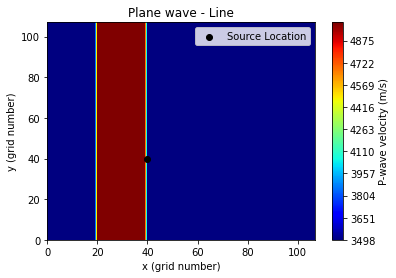

In [71]:
#Define coordinates for source
x_start=2000
x_end=2000
y_start=2000
y_end=2000
TD=0
FC=10
AMP=1
SOURCE_AZIMUTH=0
SOURCE_TYPE=1
[XSRC_grid,YSRC_grid]=SRPlacement(dh_model,x_start,x_end,y_start,y_end)
YSRC=YSRC_grid*dh_model
XSRC=XSRC_grid*dh_model
im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(XSRC_grid,YSRC_grid, color='black',label='Source Location')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Plane wave - Line')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

##### Writing SOURCEFILE

In [72]:
if isinstance(XSRC,list)==True:
    sourceoutput=np.zeros([len(YSRC),7])
    for n in range(len(YSRC)):
        sourceoutput[n,0]=XSRC[n]
        sourceoutput[n,1]=YSRC[n]
        sourceoutput[n,2]=TD
        sourceoutput[n,3]=FC
        sourceoutput[n,4]=AMP
        sourceoutput[n,5]=SOURCE_AZIMUTH
        sourceoutput[n,6]=SOURCE_TYPE
else:
    sourceoutput=np.zeros([1,7])
    sourceoutput[0,0]=XSRC
    sourceoutput[0,1]=YSRC
    sourceoutput[0,2]=TD
    sourceoutput[0,3]=FC
    sourceoutput[0,4]=AMP
    sourceoutput[0,5]=SOURCE_AZIMUTH
    sourceoutput[0,6]=SOURCE_TYPE
file=open('source.dat','w')
np.savetxt(file,sourceoutput.astype('float16'))
file.close()

##### JSON Update

In [73]:
json_update={'Source':'comment','SOURCE_SHAPE':SOURCE_SHAPE,'SIGNAL_FILE':SIGNAL_FILE,'SOURCE_TYPE':SOURCE_TYPE,'SRCREC':SRCREC,'SOURCE_FILE':SOURCE_FILE,'RUN_MULTIPLE_SHOTS':RUN_MULTIPLE_SHOTS,'PLANE_WAVE_DEPTH':PLANE_WAVE_DEPTH,'PLANE_WAVE_ANGLE':PLANE_WAVE_ANGLE,'TS':TS}
json_output.update(json_update)

#### 4.6 Generation of models

In [74]:
READMOD=1
MFILE='model/test'
WRITE_MODELFILES=0

##### JSON Update

In [75]:
json_update={'READMOD':READMOD,'MFILE':MFILE,'WRITE_MODELFILES':WRITE_MODELFILES}
json_output.update(json_update)

#### 4.7 Q-approximation

In [76]:
L=0
FL1=5
TAU=0.00001

##### JSON Update

In [77]:
json_update={'L':L,'FL1':FL1,'TAU':TAU}
json_output.update(json_update)

#### 4.8 Boundary conditions

In [78]:
FREE_SURF=1
BOUNDARY=0
FW=10
ABS_TYPE=1
NPOWER= 4
K_MAX_CPML=1
VPPML=3500
FPML=5
DAMPING=8

##### JSON Update

In [79]:
json_update={'FREE_SURF':FREE_SURF,'BOUNDARY':BOUNDARY,'FW':FW,'ABS_TYPE':ABS_TYPE,'NPOWER':NPOWER,'K_MAX_CPML':K_MAX_CPML,'VPPML':VPPML,'FPML':FPML,'DAMPING':DAMPING}
json_output.update(json_update)

#### 4.9 Wavefield snapshots

In [80]:
SNAP=4
TSNAP1=6.6e-3
TSNAP2=4.8
TSNAPINC=0.2
IDX=1
IDY=1
SNAP_FORMAT=3
SNAP_FILE='./snap/test'

##### JSON Update

In [81]:
json_update={'SNAP':SNAP,'TSNAP1':TSNAP1,'TSNAP2':TSNAP2,'TSNAPINC':TSNAPINC,'IDX':IDX,'IDY':IDY,'SNAP_FORMAT':SNAP_FORMAT,'SNAP_FILE':SNAP_FILE}
json_output.update(json_update)

#### 4.10 Receivers
Receivers setup

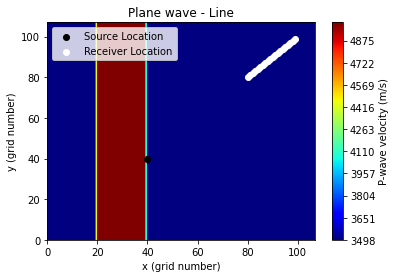

In [82]:
x_start=4000
x_end=5000
y_start=4000
y_end=5000

[XREC_grid,YREC_grid]=SRPlacement(dh_model,x_start,x_end,y_start,y_end)
YREC=YREC_grid*dh_model
XREC=XREC_grid*dh_model
im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(XSRC_grid,YSRC_grid, color='black',label='Source Location')
plt.scatter(XREC_grid,YREC_grid, color='white',label='Receiver Location')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Plane wave - Line')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

In [83]:
SEISMO=4
READREC=0
REC_FILE='./receiver/receiver.dat'
REFREC_TUPLE=str(0)+' , '+str(0)
REC1_TUPLE=str(x_start)+' , '+str(y_start)
REC2_TUPLE=str(x_end)+' , '+str(y_end)
NGEOPH=1

##### JSON Update

In [84]:
json_update={'SEISMO':SEISMO,'READREC':READREC,'REC_FILE':REC_FILE,'REFRECX, REFRECY': REFREC_TUPLE,'XREC1, YREC1':REC1_TUPLE,'XREC2, YREC2':REC2_TUPLE,'NGEOPH':NGEOPH}
json_output.update(json_update)

#### 4.11 Receiver array

In [85]:
REC_ARRAY=0
REC_ARRAY_DEPTH=70
REC_ARRAY_DIST=40
DRX=4

##### JSON Update

In [86]:
json_update={'REC_ARRAY':REC_ARRAY,'REC_ARRAY_DEPTH':REC_ARRAY_DEPTH,'REC_ARRAY_DIST':REC_ARRAY_DIST,'DRX':DRX}
json_output.update(json_update)

#### 4.12 Seismograms

In [87]:
NDT=1
SEIS_FORMAT=4
SEIS_FILE='./su/test'

##### JSON Update

In [88]:
json_update={'NDT':NDT,'SEIS_FORMAT':SEIS_FORMAT,'SEIS_FILE':SEIS_FILE}
json_output.update(json_update)

#### 4.13 Monitoring the simulation

In [89]:
LOG=1
LOG_FILE='log/test.log/'
OUT_TIMESTEP_INFO=10

##### JSON Update

In [90]:
json_update={'LOG_FILE':LOG_FILE,'LOG':LOG,'OUT_TIMESTEP_INFO':OUT_TIMESTEP_INFO}
json_output.update(json_update)

#### 4.14 Checkpointing

In [91]:
CHECKPTREAD=0
CHECKPTWRITE=0
CHECKPT_FILE='tmp/checkpoint_sofi2D'

##### JSON Update

In [92]:
json_update={'CHECKPTREAD':CHECKPTREAD,'CHECKPTWRITE':CHECKPTWRITE,'CHECKPT_FILE':CHECKPT_FILE}
json_output.update(json_update)

#### 4.15 JSON File Preview

In [94]:
jsonfile = json.dumps(json_output)
print(jsonfile)

{"Domain Decomposition": "comment", "NPROCX": 4, "NPROCY": 2, "FD order": "comment", "FDORDER": 2, "FDORDER_TIME": 2, "MAXRELERROR": 1, "2-D Grid": "comment", "NX": 108, "NY": 108, "DH": 50, "Time Stepping": "commnent", "TIME": 5, "DT": 0.006, "Source": "comment", "SOURCE_SHAPE": 1, "SIGNAL_FILE": "signal_mseis.tz", "SOURCE_TYPE": 1, "SRCREC": 1, "SOURCE_FILE": "./sources/source.dat", "RUN_MULTIPLE_SHOTS": 0, "PLANE_WAVE_DEPTH": 5, "PLANE_WAVE_ANGLE": 89, "TS": 0.2, "READMOD": 1, "MFILE": "model/test", "WRITE_MODELFILES": 0, "L": 0, "FL1": 5, "TAU": 1e-05, "FREE_SURF": 1, "BOUNDARY": 0, "FW": 10, "ABS_TYPE": 1, "NPOWER": 4, "K_MAX_CPML": 1, "VPPML": 3500, "FPML": 5, "DAMPING": 8, "SNAP": 4, "TSNAP1": 0.0066, "TSNAP2": 4.8, "TSNAPINC": 0.2, "IDX": 1, "IDY": 1, "SNAP_FORMAT": 3, "SNAP_FILE": "./snap/test", "SEISMO": 4, "READREC": 0, "REC_FILE": "./receiver/receiver.dat", "REFRECX, REFRECY": "0 , 0", "XREC1, YREC1": "4000 , 4000", "XREC2, YREC2": "5000 , 5000", "NGEOPH": 1, "REC_ARRAY": 0

In [96]:
file = open("data.json", "w")
file.write(jsonfile)
file.close()